# Compute AEP

See https://github.com/NREL/floris/blob/main/examples/aep_calculation/compute_aep.py

Written by Eric Simley

Nicholas Hamilton
nicholas.hamilton@nrel.gov

2021-02-03

In [1]:
### system-level libs
import os, sys

### analysis libs
import numpy as np
import pandas as pd

### plotting libs
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import seaborn as sns

### Floris
import floris.tools as ft
import floris.tools.cut_plane as cp
import floris.tools.wind_rose as rose
import floris.tools.power_rose as pr
import floris.tools.visualization as vis
from floris.tools.optimization.scipy.yaw_wind_rose import YawOptimizationWindRose

## initialize Floris
Same setup as in the `example_input.json`, but with 5 turbines aligned axially.

In [2]:
fi = ft.floris_interface.FlorisInterface('example_input.json')

## Setup wind farm

In [3]:
# Define wind farm coordinates and layout
wf_coordinate = [39.8283, -98.5795]

# Below minimum wind speed, assumes power is zero.
minimum_ws = 3.0

# Set wind farm to N_row x N_row grid with constant spacing
# (2 x 2 grid, 5 D spacing)
D = fi.floris.farm.turbines[0].rotor_diameter
N_row = 2
spc = 5
layout_x = []
layout_y = []
for i in range(N_row):
    for k in range(N_row):
        layout_x.append(i * spc * D)
        layout_y.append(k * spc * D)
N_turb = len(layout_x)

fi.reinitialize_flow_field(
    layout_array=(layout_x, layout_y), wind_direction=[270.0], wind_speed=[8.0]
)
fi.calculate_wake()


## Visualize

Text(0.5, 1.0, 'Baseline flow for U = 8 m/s, Wind Direction = 270$^\\circ$')

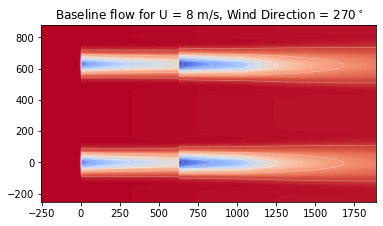

In [4]:
# Initialize the horizontal cut
hor_plane = fi.get_hor_plane(height=fi.floris.farm.turbines[0].hub_height)

# Plot and show
fig, ax = plt.subplots()
ft.visualization.visualize_cut_plane(hor_plane, ax=ax)
ax.set_title("Baseline flow for U = 8 m/s, Wind Direction = 270$^\circ$")

## Import wind rose

Correcting negative Overhang:-7.5


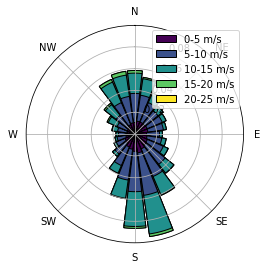

In [5]:

# Create wind rose object and import wind rose dataframe using WIND Toolkit
# HSDS API. Alternatively, load existing file with wind rose information.
calculate_new_wind_rose = False

wind_rose = rose.WindRose()

if calculate_new_wind_rose:

    wd_list = np.arange(0, 360, 5)
    ws_list = np.arange(0, 26, 1)

    df = wind_rose.import_from_wind_toolkit_hsds(
        wf_coordinate[0],
        wf_coordinate[1],
        ht=100,
        wd=wd_list,
        ws=ws_list,
        limit_month=None,
        st_date=None,
        en_date=None,
    )

else:
    df = wind_rose.load(os.path.join( os.path.expanduser('~'),'Documents/github/floris/examples/optimization/scipy/windtoolkit_geo_center_us.p'))

# plot wind rose
wind_rose.plot_wind_rose()

## Estimate wake losses

In [ ]:
%%capture 
# <-------- Comment out the line above if you want full text output

# =============================================================================
print("Finding power with and without wakes in FLORIS...")
# =============================================================================

# Instantiate the Optimization object
# Note that the optimization is not performed in this example.
yaw_opt = YawOptimizationWindRose(fi, df.wd, df.ws, minimum_ws=minimum_ws)

# Determine baseline power with and without wakes
df_base = yaw_opt.calc_baseline_power()

# Initialize power rose
case_name = "Example " + str(N_row) + " x " + str(N_row) + " Wind Farm"
power_rose = pr.PowerRose()
power_rose.make_power_rose_from_user_data(
    case_name, df, df_base["power_no_wake"], df_base["power_baseline"]
)

# Display AEP analysis
fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(6.4, 6.5))
power_rose.plot_by_direction(axarr)
power_rose.report()

plt.show()